In [ ]:
import json
import torch
import numpy as np
import torch.nn as nn

from PIL import Image
from torchvision import transforms
from sklearn.metrics import confusion_matrix
from torchvision.ops import SqueezeExcitation
from torch.utils.data import Dataset, DataLoader

#### Load Images

In [ ]:
# archive_path = '[it was google drive path]'

train_length, valid_length = 500, 72

# train_labels = json.loads(open(f'{archive_path}/data/train/annotations').read())
# valid_labels = json.loads(open(f'{archive_path}/data/valid/annotations').read())

train_labels = json.loads(open('../data/train/annotations').read())
valid_labels = json.loads(open('../data/valid/annotations').read())

# 0: turtle and 1: penguin
train_labels = [0 if item["category_id"] == 2 else 1 for item in train_labels]
valid_labels = [0 if item["category_id"] == 2 else 1 for item in valid_labels]

#### Image normalization parameters
Check 'data_preprocessing_and_analysis.ipynb' for details

In [ ]:
mean = [0.6012, 0.6324, 0.6453]
std = [0.2472, 0.2300, 0.2304]

# Datasets and Dataloader

In [ ]:
class PenguinVSTurtleDataset(Dataset):
    """
    Dataset class for the Penguin vs Turtle classification task.

    Args:
        length (int): Length of the dataset.
        transform (callable): Transform to be applied on the images.
        annotations (list): List of image annotations.
        train (bool): Flag indicating if the dataset is for training or validation.
    """
    def __init__(self, length, annotations, train=True):
        super().__init__()
        self.len = length
        self.annotations = annotations
        self.train = train
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)), # Image resizing: 224 x 224 x 3
            transforms.RandomHorizontalFlip(), # Data augmentation: Random horizontal flip
            transforms.ToTensor(),
            transforms.Normalize(mean, std) # Normalization
        ]) if train else transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

    def __len__(self):
        return self.len

    def __getitem__(self, id):
        # path = f'{archive_path}/data/train/images/{id}.jpg' if self.train else f'{archive_path}/data/valid/images/{id}.jpg'
        path = f'../data/train/images/{id}.jpg' if self.train else f'../data/valid/images/{id}.jpg'
        image = Image.open(path).convert('RGB')
        image = self.transform(image)
        label = train_labels[id] if self.train else valid_labels[id]

        return (image, label)

In [8]:
torch.manual_seed(42)

train_set = PenguinVSTurtleDataset(train_length, train_labels, train=True)
valid_set = PenguinVSTurtleDataset(valid_length, valid_labels, train=False)

train_loader = DataLoader(train_set, batch_size=16, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_set, batch_size=16, shuffle=False, num_workers=2)

# Neural Network Architecutre: EfficientNetB0

#### MBConv Blocks
[MobileNetV2: Inverted Residuals and Linear Bottlenecks](https://arxiv.org/pdf/1801.04381)  
[Squeeze-and-Excitation Networks](https://arxiv.org/pdf/1709.01507)

In [9]:
class MBConv(nn.Module):
    """
    MBConv block for EfficientNet-B0

    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        kernel_size (int): Size of the convolutional kernel.
        stride (int): Stride for the convolutional layers.
        expand_ratio (int): Expansion ratio for the bottleneck.
        drop_out (float): Dropout rate.
        survival_prob (float): Survival probability for stochastic depth.
        se_ratio (float): Squeeze-and-Excitation ratio.
    """
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, stride: int, expand_ratio: int, drop_out: float = 0.2, survival_prob: float = 0.8, se_ratio: float = 0.25):
        super(MBConv, self).__init__()
        self.stride = stride
        self.se_ratio = se_ratio
        # Survival probability for stochastic depth.
        self.survival_prob = survival_prob

        # Residual Connection Possibility
        self.residual = self.stride == 1 and in_channels == out_channels

        expanded_channels = in_channels * expand_ratio

        layers = []

        # 1. Expansion Layer (1x1 Conv)
        if expand_ratio > 1:
            layers.extend([
                nn.Conv2d(in_channels, expanded_channels, kernel_size=1, bias=False),
                nn.BatchNorm2d(expanded_channels),
                nn.SiLU(inplace=True)
            ])

        # 2. Depthwise Convolution (3x3 Conv)
        layers.extend([
            nn.Conv2d(expanded_channels, expanded_channels, kernel_size=kernel_size, stride=stride, padding=kernel_size//2, groups=expanded_channels, bias=False),
            nn.BatchNorm2d(expanded_channels),
            nn.SiLU(inplace=True)
        ])

        # 3. Squeeze-and-Excitation Layer
        if self.se_ratio is not None:
            layers.append(SqueezeExcitation(input_channels=expanded_channels, squeeze_channels=int(expanded_channels * se_ratio)))

        # 4. Projection Layer (1x1 Conv)
        layers.extend([
            nn.Conv2d(expanded_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.SiLU(inplace=True),
            nn.Dropout(drop_out)  # Dropout layer with a rate of 0.2
        ])

        self.block = nn.Sequential(*layers)

        # self.stochastic_depth = StochasticDepth(p=self.survival_prob, mode="row")

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x (Tensor): Input tensor of shape (batch_size, in_channels, height, width)

        Returns:
            Tensor: Output tensor of shape (batch_size, out_channels, height, width)
        """
        if self.residual:
            p = self.survival_prob
            if np.random.choice([0, 1], p=[1-p, p]) == 1:
                out = self.block(x) + x
            else:
                out = x
        else:
            out = self.block(x)

        return out

#### Main Architecture
[EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks](https://arxiv.org/pdf/1905.11946)

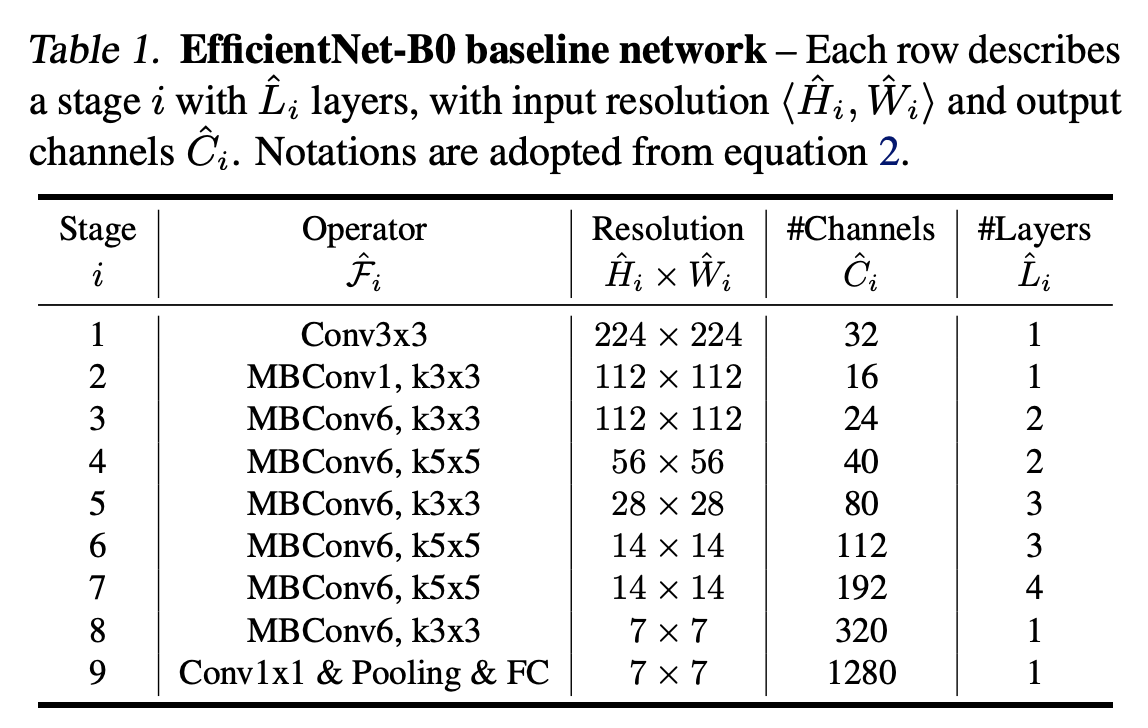

In [10]:
class EfficientNetB0(nn.Module):
    """
    EfficientNet-B0 model

    Args:
        num_classes (int): Number of output classes.
        stochastic_depth_prob (float): Stochastic depth probability.
    """
    def __init__(self, num_classes: int, stochastic_depth_prob: float=0.8):
        super(EfficientNetB0, self).__init__()

        # (out_channels, expansion_factor, kernel_size, stride, repeats)
        config: list[tuple[int, int, int, int]] = [
            (16, 1, 3, 1, 1),
            (24, 6, 3, 2, 2),
            (40, 6, 5, 2, 2),
            (80, 6, 3, 2, 3),
            (112, 6, 5, 1, 3),
            (192, 6, 5, 2, 4),
            (320, 6, 3, 1, 1),
        ]

        # 1. Initial Convolution Layer (Stem)
        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.SiLU(inplace=True)
        )

        # 2. MBConv Blocks
        blocks = []
        in_channels = 32
        block_idx = 0
        for out_channels, expand_ratio, kernel_size, stride, repeats in config:
            for i in range(repeats):
                current_stride = stride if i == 0 else 1
                blocks.append(MBConv(in_channels, out_channels, kernel_size, current_stride, expand_ratio, survival_prob=stochastic_depth_prob))
                in_channels = out_channels
                block_idx += 1

        self.main_blocks = nn.Sequential(*blocks)

        # 3. Head
        self.head = nn.Sequential(
            nn.Conv2d(320, 1280, kernel_size=1, bias=False),
            nn.BatchNorm2d(1280),
            nn.SiLU(inplace=True),
            nn.AdaptiveAvgPool2d(1),  # Global Average Pooling
            nn.Flatten(),
            nn.Linear(1280, num_classes)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x (Tensor): Input tensor of shape (batch_size, 3, height, width)

        Returns:
            Tensor: Output tensor of shape (batch_size, num_classes)
        """
        x = self.stem(x)
        x = self.main_blocks(x)
        x = self.head(x)
        return x

#### Training Setup and the Architecture Summary

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EfficientNetB0(num_classes=2, stochastic_depth_prob=0.2)
model.to(device)

EfficientNetB0(
  (stem): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (main_blocks): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
        (3): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Sigmoid()
        )
        (4): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_

# Functions to train & evaluate models

In [22]:
def evaluate(model, valid_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            loss = criterion(outputs, labels)

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    average_loss = running_loss / len(valid_loader)
    accuracy = correct_predictions / total_samples
    print(f"Validation Loss: {average_loss:.4f} - Validation Accuracy: {accuracy:.4f}")

    cm = confusion_matrix(all_labels, all_predictions)
    print("Confusion Matrix:")
    print(cm)

    # Calculate precision and recall
    true_positives = cm[1, 1]
    false_positives = cm[0, 1]
    false_negatives = cm[1, 0]

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0


    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    # Calculate F1-score, handling the case where precision + recall is zero
    if (precision + recall) == 0:
        f1_score = 0
    else:
        f1_score = 2 * ((precision * recall) / (precision + recall))
    print(f'F1-score: {f1_score}')


    return accuracy

def train_model(model, train_loader, criterion, optimizer, num_epochs, info):
    best_accuracy = 0
    best_accuracy_valid = 0

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)

            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)
            print('.', end='', flush=True)

        average_loss = running_loss / len(train_loader)
        accuracy = correct_predictions / total_samples

        print(f"\n --- Epoch {epoch + 1}/{num_epochs} - Train Loss: {average_loss:.4f} - Train Accuracy: {accuracy:.4f}")

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(), f"{info}_train.pth")

        valid_accuracy = evaluate(model, valid_loader, criterion)
        if valid_accuracy > best_accuracy_valid:
            best_accuracy_valid = valid_accuracy
            torch.save(model.state_dict(), f"{info}_valid.pth")

In [13]:
# Evaluate the model prediction probabilities, and return the list of probabilities, class predictions and sample paths
def evaluate_proba(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    all_proba = []
    cls_predictions = []

    with torch.no_grad():
        for inputs in data_loader:
            inputs = inputs.to(device)

            outputs = model(inputs)

            # Determine the class probabilities and predictions of the inputs
            model_proba = F.softmax(outputs, dim=1)

            for proba in model_proba:
                cls_predict = torch.argmax(proba).item()
                input_proba = max(proba[0].item(), proba[1].item())
                all_proba.append(input_proba)
                cls_predictions.append(cls_predict)

    # The predicted class corresponds to the class of the largest predicted probability
    idx = np.argmax(all_proba)
    cls_prediction = cls_predictions[idx]

    return all_proba, cls_prediction

# Lion Optimizer Model
[paper](https://arxiv.org/pdf/2302.06675)  
Replicated from: [git hub](https://github.com/lucidrains/lion-pytorch/tree/main)

In [14]:
"""PyTorch implementation of the Lion optimizer."""
import torch
from torch.optim.optimizer import Optimizer


class Lion(Optimizer):
  r"""Implements Lion algorithm."""

  def __init__(self, params, lr=1e-4, betas=(0.9, 0.99), weight_decay=0.0):
    """Initialize the hyperparameters.

    Args:
      params (iterable): iterable of parameters to optimize or dicts defining
        parameter groups
      lr (float, optional): learning rate (default: 1e-4)
      betas (Tuple[float, float], optional): coefficients used for computing
        running averages of gradient and its square (default: (0.9, 0.99))
      weight_decay (float, optional): weight decay coefficient (default: 0)
    """

    if not 0.0 <= lr:
      raise ValueError('Invalid learning rate: {}'.format(lr))
    if not 0.0 <= betas[0] < 1.0:
      raise ValueError('Invalid beta parameter at index 0: {}'.format(betas[0]))
    if not 0.0 <= betas[1] < 1.0:
      raise ValueError('Invalid beta parameter at index 1: {}'.format(betas[1]))
    defaults = dict(lr=lr, betas=betas, weight_decay=weight_decay)
    super().__init__(params, defaults)

  @torch.no_grad()
  def step(self, closure=None):
    """Performs a single optimization step.

    Args:
      closure (callable, optional): A closure that reevaluates the model
        and returns the loss.

    Returns:
      the loss.
    """
    loss = None
    if closure is not None:
      with torch.enable_grad():
        loss = closure()

    for group in self.param_groups:
      for p in group['params']:
        if p.grad is None:
          continue

        # Perform stepweight decay
        p.data.mul_(1 - group['lr'] * group['weight_decay'])

        grad = p.grad
        state = self.state[p]
        # State initialization
        if len(state) == 0:
          # Exponential moving average of gradient values
          state['exp_avg'] = torch.zeros_like(p)

        exp_avg = state['exp_avg']
        beta1, beta2 = group['betas']

        # Weight update
        update = exp_avg * beta1 + grad * (1 - beta1)
        p.add_(torch.sign(update), alpha=-group['lr'])
        # Decay the momentum running average coefficient
        exp_avg.mul_(beta2).add_(grad, alpha=1 - beta2)

    return loss

# Training with Validation

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = Lion(model.parameters(), lr=0.001)

num_epochs = 30
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
train_model(model, train_loader, criterion, optimizer, num_epochs, 'EfficientNetB0_Lion')

................................
 --- Epoch 1/30 - Train Loss: 0.6479 - Train Accuracy: 0.6440
Validation Loss: 3.1234 - Validation Accuracy: 0.5000
Confusion Matrix:
[[ 0 36]
 [ 0 36]]
Precision: 0.5
Recall: 1.0
F1-score: 0.6666666666666666
................................
 --- Epoch 2/30 - Train Loss: 0.5565 - Train Accuracy: 0.7260
Validation Loss: 1.2221 - Validation Accuracy: 0.6250
Confusion Matrix:
[[29  7]
 [20 16]]
Precision: 0.6956521739130435
Recall: 0.4444444444444444
F1-score: 0.5423728813559322
................................
 --- Epoch 3/30 - Train Loss: 0.5166 - Train Accuracy: 0.7500
Validation Loss: 1.4461 - Validation Accuracy: 0.5833
Confusion Matrix:
[[32  4]
 [26 10]]
Precision: 0.7142857142857143
Recall: 0.2777777777777778
F1-score: 0.4
................................
 --- Epoch 4/30 - Train Loss: 0.4939 - Train Accuracy: 0.7780
Validation Loss: 2.3601 - Validation Accuracy: 0.5417
Confusion Matrix:
[[18 18]
 [15 21]]
Precision: 0.5384615384615384
Recall: 0.583